EEM5038 Görüntü Analizinde Derin Öğrenme Uygulamaları Dersi Ödev 1


PyTorch Kütüphanesi ve Temel Modüllerin İçe Aktarılması

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torch.utils.data import Subset, random_split

Yapay sinir ağı 2 konvolusyonel katman ve 3 fully
connected katmandan oluşmaktadır. İlk
konvolusyonel katman, 64 kanallı ve kernel
büyüklüğü 5x5. Bu katmanı, parametric ReLU
aktivasyon fonksiyonu ve max pooling katmanı
izlemekte. Pooling katmanı sonunda, aktivasyon
haritasının büyüklüğü yarıya inmekte. Not: Kernel
büyüklüğüne uygun olarak girişe padding
uygulayınız. İkinci konvolusyonel katman, birinci
konvolusyonel katmandan farklı olarak, 128
kanala sahip ve 3x3 büyüklüğünden
konvolusyonel kernel kullanmakta.

In [38]:
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, padding=2)
        self.prelu1 = nn.PReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3)
        self.prelu2 = nn.PReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(128 * 6 * 6, 1280)
        self.prelu3 = nn.PReLU()
        self.fc2 = nn.Linear(1280, 640)
        self.prelu4 = nn.PReLU()
        self.fc3 = nn.Linear(640, 2)

    def forward(self, x):
      x = self.pool1(self.prelu1(self.conv1(x)))
      x = self.pool2(self.prelu2(self.conv2(x)))
      x = self.flatten(x)
      x = self.prelu3(self.fc1(x))
      x = self.prelu4(self.fc2(x))
      x = self.fc3(x)

      return x

MNIST Veri Kümesi İçin Asal Sayıları 0-1 Olarak İşaretleme ve Veri Ön İşleme

In [45]:
class MNISTDataLoader:
    def __init__(self, batch_size=256, train_ratio=0.8):
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

        train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

        train_images = train_dataset.data.unsqueeze(1).float() / 255.0
        train_labels = train_dataset.targets

        prime_labels = torch.tensor([1 if n == 2 or (n > 1 and n % 2 != 0 and all(n % i != 0 for i in range(3, int(n**0.5) + 1, 2))) else 0 for n in train_labels], dtype=torch.long)

        self.train_dataset = TensorDataset(train_images, prime_labels)

        total_size = len(train_dataset)
        train_size = int(train_ratio * total_size)
        val_size = total_size - train_size

        train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

        self.trainloader = DataLoader(train_subset, shuffle=True, batch_size=batch_size)
        self.valloader = DataLoader(val_subset, shuffle=False, batch_size=batch_size)


In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data_loader = MNISTDataLoader(batch_size=256, train_ratio=0.8)
train_loader = data_loader.trainloader
val_loader = data_loader.valloader
model = CustomModel().to(device)

In [41]:
class CustomModelTrainer():
    def __init__(self, model, trainloader, valloader,criterion, num_epochs=40):
        self.model = model
        self.criterion=criterion
        self.trainloader = trainloader
        self.valloader = valloader
        self.num_epochs = num_epochs
        self.running_loss = 0.0
        self.correct_predictions = 0
        self.total_samples = 0
        self.train_acc=[]
        self.train_losses=[]
        self.val_acc=[]
        self.val_losses=[]

    def train(self,mmn):
      optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=mmn)

      for epoch in range(self.num_epochs):
          self.model.train()

          for inputs, labels in self.trainloader:
              inputs, labels = inputs.to(device), labels.to(device)

              optimizer.zero_grad()

              outputs = model(inputs)
              loss = self.criterion(outputs, labels)
              loss.backward()
              optimizer.step()

              self.running_loss += loss.item()
              _, predicted = torch.max(outputs.data, 1)
              self.total_samples += labels.size(0)
              self.correct_predictions += (predicted == labels).sum().item()

          train_accuracy = self.correct_predictions / self.total_samples
          self.train_acc.append(train_accuracy)
          self.train_losses.append(self.running_loss / len(self.trainloader))

          self.model.eval()
          running_val_loss = 0.0
          correct_predictions_val = 0
          self.total_samples_val = 0

          with torch.no_grad():
              for val_inputs, val_labels in self.valloader:
                  val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                  val_outputs = self.model(val_inputs)
                  val_loss = self.criterion(val_outputs, val_labels)

                  running_val_loss += val_loss.item()

                  _, val_predicted = torch.max(val_outputs.data, 1)
                  self.total_samples_val += val_labels.size(0)
                  correct_predictions_val += (val_predicted == val_labels).sum().item()

          val_accuracy = correct_predictions_val / self.total_samples_val
          self.val_acc.append(val_accuracy)
          self.val_losses.append(running_val_loss / len(self.valloader))

          print(f'Epoch {epoch + 1}/{self.num_epochs}, '
                  f'Training Loss: {self.train_losses[-1]}, Training Acc: {self.train_acc[-1]}, '
                  f'Validation Loss: {self.val_losses[-1]}, Validation Acc: {self.val_acc[-1]}')

    def run_training(self, momentums):
        for momentum in momentums:
            print(f'Training Momentum: {momentum}...')


            self.train(momentum)
            self.plot_metrics(self.train_losses, self.train_acc, self.val_losses, self.val_acc, momentum)

            model_filename = f'model_momentum_{momentum}.pth'
            torch.save(model.state_dict(), model_filename)
    def plot_metrics(self,train_losses, train_accuracies, val_losses, val_accuracies, momentum):
        epochs = range(1, len(train_losses) + 1)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, label=f'Momentum={momentum}')
        plt.title('Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_accuracies, label=f'Momentum={momentum}')
        plt.title('Training Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, val_losses, label=f'Momentum={momentum}')
        plt.title('Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, val_accuracies, label=f'Momentum={momentum}')
        plt.title('Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()

Training Momentum: 0.01...
Epoch 1/40, Training Loss: 0.3917867073274039, Training Acc: 0.8134583333333333, Validation Loss: 0.12448304733063312, Validation Acc: 0.9585
Epoch 2/40, Training Loss: 0.47560210662715613, Training Acc: 0.8928125, Validation Loss: 0.06377161936239993, Validation Acc: 0.97825
Epoch 3/40, Training Loss: 0.5212833669006903, Training Acc: 0.9233819444444444, Validation Loss: 0.043214441772471086, Validation Acc: 0.9861666666666666
Epoch 4/40, Training Loss: 0.552926945304399, Training Acc: 0.939890625, Validation Loss: 0.03326487872115475, Validation Acc: 0.9886666666666667
Epoch 5/40, Training Loss: 0.5759721463570926, Training Acc: 0.9504375, Validation Loss: 0.02740082256198722, Validation Acc: 0.99025
Epoch 6/40, Training Loss: 0.5947404834126033, Training Acc: 0.9576805555555555, Validation Loss: 0.023292050186663547, Validation Acc: 0.992
Epoch 7/40, Training Loss: 0.609489568897419, Training Acc: 0.9630625, Validation Loss: 0.01994855064116022, Validation

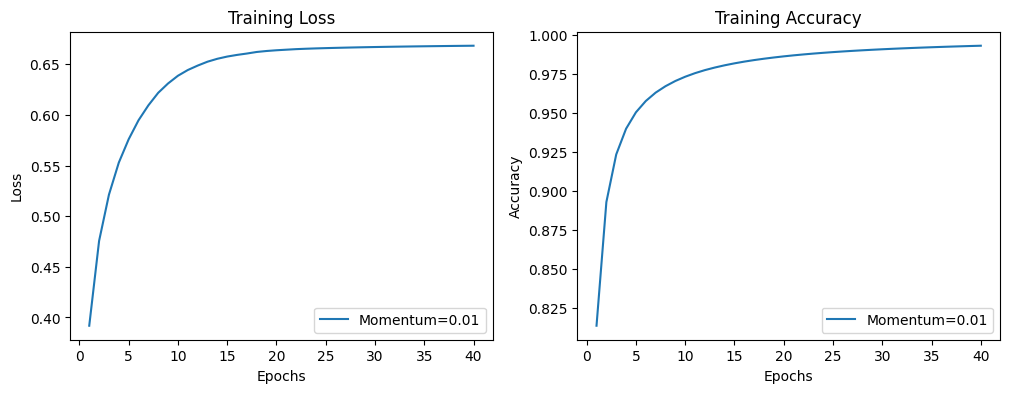

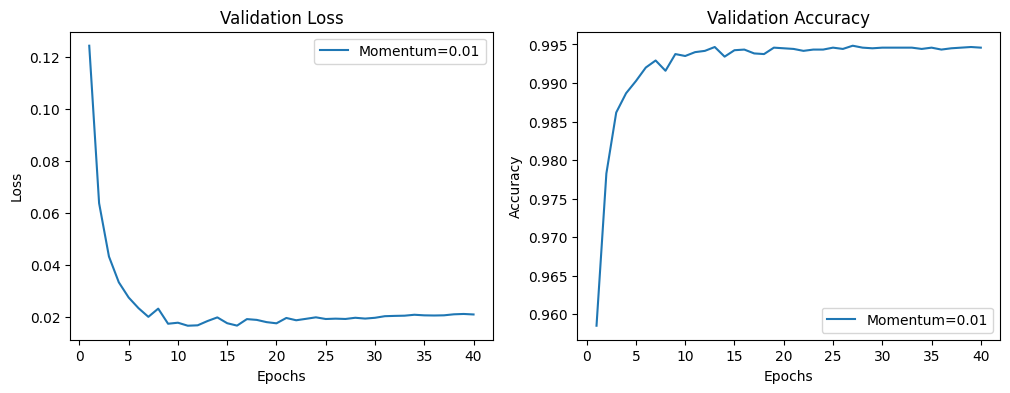

Training Momentum: 0.5...
Epoch 1/40, Training Loss: 0.6685112031801023, Training Acc: 0.993334349593496, Validation Loss: 0.021678518407846223, Validation Acc: 0.9943333333333333
Epoch 2/40, Training Loss: 0.6686040985215087, Training Acc: 0.9934930555555556, Validation Loss: 0.020922717964803016, Validation Acc: 0.9946666666666667
Epoch 3/40, Training Loss: 0.6686905925937033, Training Acc: 0.9936443798449612, Validation Loss: 0.021552626179924272, Validation Acc: 0.9946666666666667
Epoch 4/40, Training Loss: 0.6687688299782706, Training Acc: 0.9937888257575758, Validation Loss: 0.02137683996745104, Validation Acc: 0.99475
Epoch 5/40, Training Loss: 0.6688407152628908, Training Acc: 0.9939268518518518, Validation Loss: 0.022068266704391524, Validation Acc: 0.99475
Epoch 6/40, Training Loss: 0.6689065505501689, Training Acc: 0.9940588768115942, Validation Loss: 0.022107976474681563, Validation Acc: 0.9944166666666666
Epoch 7/40, Training Loss: 0.6689689543676628, Training Acc: 0.99418

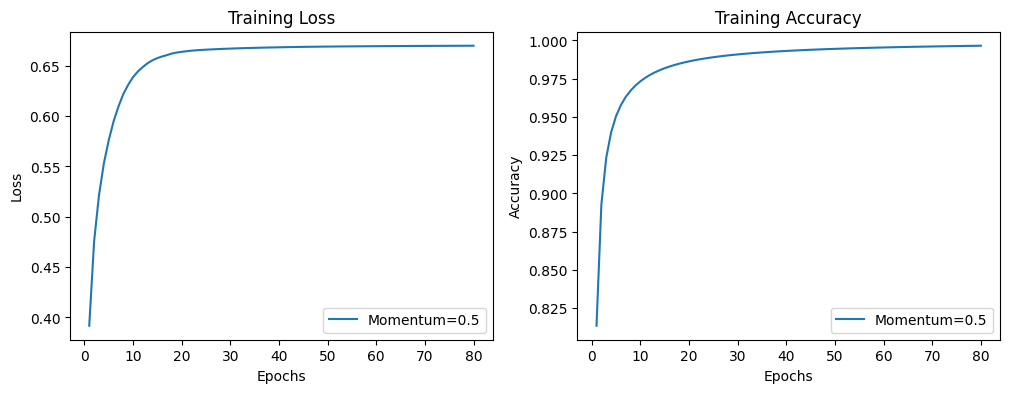

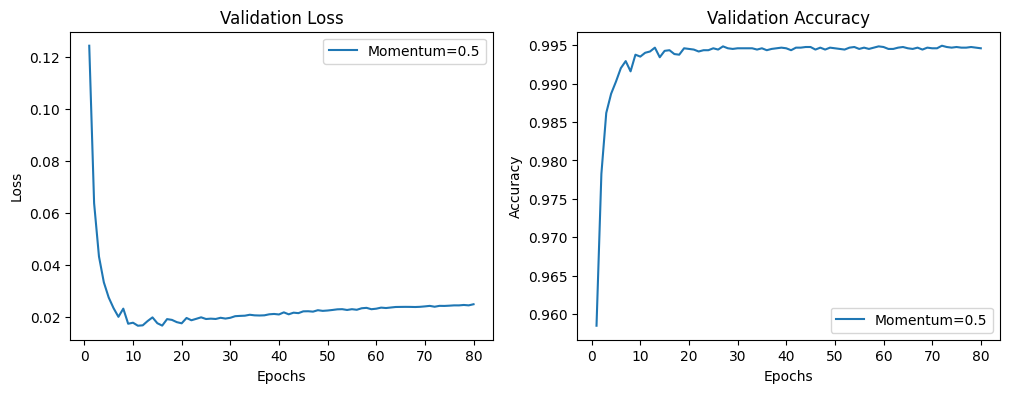

Training Momentum: 0.99...
Epoch 1/40, Training Loss: nan, Training Acc: 0.9936507201646091, Validation Loss: nan, Validation Acc: 0.6063333333333333
Epoch 2/40, Training Loss: nan, Training Acc: 0.9888879573170731, Validation Loss: nan, Validation Acc: 0.6063333333333333
Epoch 3/40, Training Loss: nan, Training Acc: 0.9842399598393574, Validation Loss: nan, Validation Acc: 0.6063333333333333
Epoch 4/40, Training Loss: nan, Training Acc: 0.979702628968254, Validation Loss: nan, Validation Acc: 0.6063333333333333
Epoch 5/40, Training Loss: nan, Training Acc: 0.9752720588235294, Validation Loss: nan, Validation Acc: 0.6063333333333333
Epoch 6/40, Training Loss: nan, Training Acc: 0.9709445251937985, Validation Loss: nan, Validation Acc: 0.6063333333333333
Epoch 7/40, Training Loss: nan, Training Acc: 0.9667164750957854, Validation Loss: nan, Validation Acc: 0.6063333333333333
Epoch 8/40, Training Loss: nan, Training Acc: 0.9625845170454546, Validation Loss: nan, Validation Acc: 0.6063333

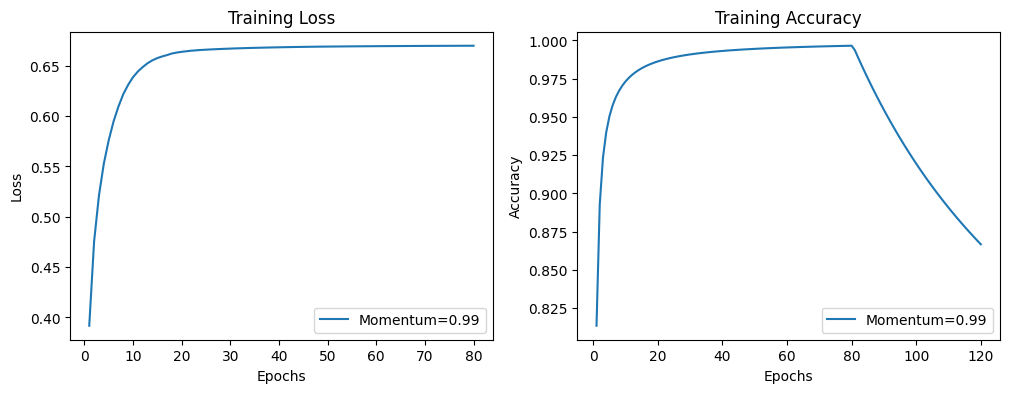

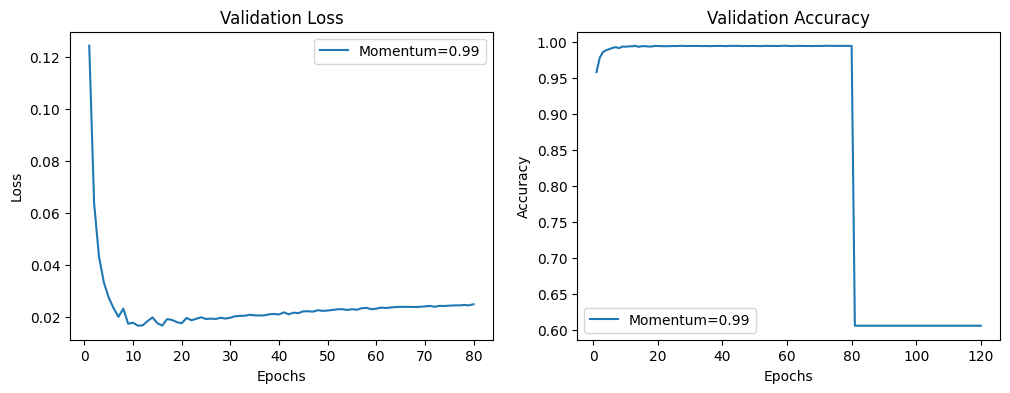

In [42]:
trainer = CustomModelTrainer(
    model=model,
    trainloader=train_loader,
    valloader=val_loader,
    criterion=nn.CrossEntropyLoss(),
    num_epochs=40
)
momentums = [0.01, 0.5, 0.99]
trainer.run_training(momentums)

Modelin Gerçek Verilerle Doğruluk Testi

In [47]:
def test(model_filename, input_image):

    model.load_state_dict(torch.load(model_filename))
    model.eval()

    with torch.no_grad():
        input_image = input_image.to(device)
        output = model(input_image.unsqueeze(0))
        _, predicted_class = torch.max(output, 1)

    return predicted_class.item()

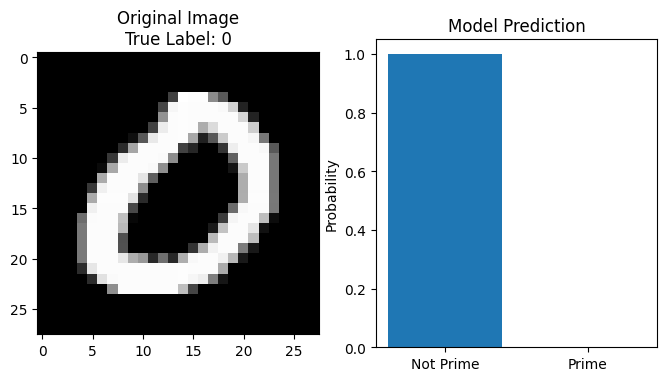

In [48]:
import random

model_filename = 'model_momentum_0.01.pth'

index = random.randint(0, len(data_loader.train_dataset) - 1)
input_image, true_label = data_loader.train_dataset[index]

predicted_class = test(model_filename, input_image)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(input_image.squeeze().numpy(), cmap='gray')
plt.title(f'Original Image\nTrue Label: {true_label}')

plt.subplot(1, 2, 2)
plt.bar(range(2), [1 - predicted_class, predicted_class], tick_label=['Not Prime', 'Prime'])
plt.title('Model Prediction')
plt.ylabel('Probability')
plt.show()